In [41]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans

# Understand Data

In [42]:
data = pd.read_csv('out5.csv')

In [43]:
data.head()

ClientMacAddr        lat        lng                    localtime  \
0  fc:42:03:75:a7:59 -22.815294 -43.246665  2019-08-01 02:56:43.532 UTC   
1  90:73:5a:c7:ca:0b -22.815237 -43.246500  2019-08-01 02:56:45.933 UTC   
2  38:9a:f6:e1:eb:2b -22.815451 -43.246753  2019-08-01 02:56:51.442 UTC   
3  da:a1:19:d3:a8:9d -22.815583 -43.246471  2019-08-01 02:56:58.292 UTC   
4  c2:4f:c6:5d:d7:a3 -22.815462 -43.246588  2019-08-01 02:56:59.354 UTC   

     Level  
0  Level 2  
1  Level 2  
2  Level 2  
3  Level 2  
4  Level 2

In [44]:
data.drop('Level',inplace=True,axis=1)

In [45]:
def convert_datetime(sample):
    sample['timestamp'] = pd.to_datetime(sample['localtime'].str.slice(0,19))
    return sample

In [46]:
dateconvert_data= convert_datetime(data)

In [47]:
dateconvert_data.head()

ClientMacAddr        lat        lng                    localtime  \
0  fc:42:03:75:a7:59 -22.815294 -43.246665  2019-08-01 02:56:43.532 UTC   
1  90:73:5a:c7:ca:0b -22.815237 -43.246500  2019-08-01 02:56:45.933 UTC   
2  38:9a:f6:e1:eb:2b -22.815451 -43.246753  2019-08-01 02:56:51.442 UTC   
3  da:a1:19:d3:a8:9d -22.815583 -43.246471  2019-08-01 02:56:58.292 UTC   
4  c2:4f:c6:5d:d7:a3 -22.815462 -43.246588  2019-08-01 02:56:59.354 UTC   

            timestamp  
0 2019-08-01 02:56:43  
1 2019-08-01 02:56:45  
2 2019-08-01 02:56:51  
3 2019-08-01 02:56:58  
4 2019-08-01 02:56:59

In [48]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
datatime=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='30T')]).size().reset_index(name='count')

In [49]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
M_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='M')]).size().reset_index(name='count')

In [50]:
dateconvert_data.localtime=pd.to_datetime(dateconvert_data.timestamp)
D_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='D')]).size().reset_index(name='count')

In [51]:
W_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='7D')]).size().reset_index(name='count')

In [52]:
H_data=dateconvert_data.groupby([pd.Grouper(key='timestamp',freq='H')]).size().reset_index(name='count')

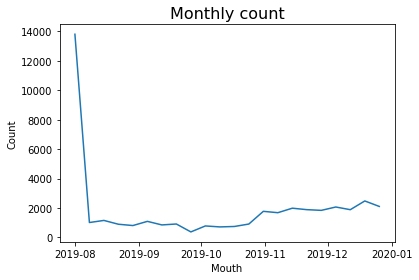

In [53]:
import matplotlib.pyplot as plt
plt.title('Monthly count', fontsize=16)
plt.plot(W_data['timestamp'],W_data['count'])
plt.ylabel('Count')
plt.xlabel('Mouth')
plt.show()

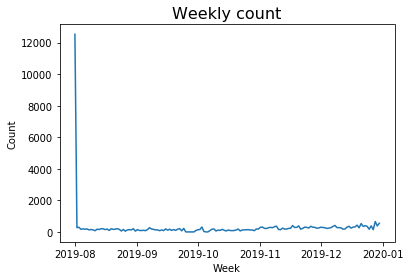

In [54]:
import matplotlib.pyplot as plt
plt.title('Weekly count', fontsize=16)
plt.plot(D_data['timestamp'],D_data['count'])
plt.ylabel('Count')
plt.xlabel('Week')
plt.show()

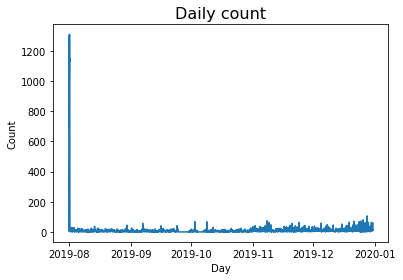

In [55]:
import matplotlib.pyplot as plt
plt.title('Daily count', fontsize=16)
plt.plot(H_data['timestamp'],H_data['count'])
plt.ylabel('Count')
plt.xlabel('Day')
plt.show()

In [56]:
data=data.groupby([pd.Grouper(key='timestamp',freq='10T')]).size().reset_index(name='count')
data['time']=pd.to_datetime(data['timestamp']).dt.round('10T').dt.strftime('%Y-%m-%d-%H-%M')  
data.drop('timestamp',inplace=True,axis=1)
data=data[["time","count"]]
data.to_csv('data5.csv',index=False)  


In [57]:
data.describe()

count
count  21871.000000
mean       1.912990
std       10.379488
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max      284.000000

# LSTM

In [58]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.layers import LSTM,RNN
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.model_selection import StratifiedKFold,cross_val_score
%matplotlib inline

In [59]:
#Data input
dataframe = read_csv("data5.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6
#we use 6=60min to find next 10min result
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Model Cross Validation Choose layers

In [60]:
#Model Cross Validation Choose layers
listscore = []
for layer in range(1,10):
    data = []
    for index in range(len(dataset) - lookback):
        data.append(dataset[index: index + lookback])
    data = numpy.array(data)
    row = int(round(0.7 * data.shape[0]))
    train = data[:row, :]
    numpy.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = data[row:, :-1]
    y_test = data[row:, -1]
    X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(layer, input_shape=(lookback-1,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
    model.summary()
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    listscore .append(testScore)
    Best=min(listscore)
    print(listscore)
    print(Best)

Epoch 1/10
15305/15305 [==============================] - 1s 77us/step - loss: 0.0023
Epoch 2/10
15305/15305 [==============================] - 0s 27us/step - loss: 0.0020
Epoch 3/10
15305/15305 [==============================] - 0s 27us/step - loss: 0.0019
Epoch 4/10
15305/15305 [==============================] - 0s 28us/step - loss: 0.0019
Epoch 5/10
15305/15305 [==============================] - 0s 27us/step - loss: 0.0019
Epoch 6/10
15305/15305 [==============================] - 0s 26us/step - loss: 0.0018
Epoch 7/10
15305/15305 [==============================] - 0s 26us/step - loss: 0.0018
Epoch 8/10
15305/15305 [==============================] - 0s 26us/step - loss: 0.0018
Epoch 9/10
15305/15305 [==============================] - 0s 26us/step - loss: 0.0018
Epoch 10/10
15305/15305 [==============================] - 0s 26us/step - loss: 0.0017
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape         

15305/15305 [==============================] - 0s 30us/step - loss: 2.0130e-04
Epoch 5/10
15305/15305 [==============================] - 1s 33us/step - loss: 1.9619e-04
Epoch 6/10
15305/15305 [==============================] - 0s 32us/step - loss: 1.9700e-04
Epoch 7/10
15305/15305 [==============================] - 0s 29us/step - loss: 1.9079e-04
Epoch 8/10
15305/15305 [==============================] - 0s 29us/step - loss: 1.8852e-04
Epoch 9/10
15305/15305 [==============================] - 0s 29us/step - loss: 1.8578e-04
Epoch 10/10
15305/15305 [==============================] - 0s 29us/step - loss: 1.8950e-04
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 6)                 192       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 199
Trainable

In [61]:
#The 1 layer have the lowest RMSE

In [62]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [63]:
#Model
model = Sequential()
model.add(LSTM(1, input_shape=(lookback-1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)
model.summary()

Epoch 1/10
15305/15305 [==============================] - 1s 93us/step - loss: 0.0014
Epoch 2/10
15305/15305 [==============================] - 0s 31us/step - loss: 0.0011
Epoch 3/10
15305/15305 [==============================] - 0s 32us/step - loss: 7.5740e-04
Epoch 4/10
15305/15305 [==============================] - 0s 28us/step - loss: 4.4504e-04
Epoch 5/10
15305/15305 [==============================] - 0s 28us/step - loss: 2.6648e-04
Epoch 6/10
15305/15305 [==============================] - 0s 28us/step - loss: 1.9948e-04
Epoch 7/10
15305/15305 [==============================] - 0s 28us/step - loss: 1.7836e-04
Epoch 8/10
15305/15305 [==============================] - 0s 27us/step - loss: 1.7172e-04
Epoch 9/10
15305/15305 [==============================] - 0s 28us/step - loss: 1.6953e-04
Epoch 10/10
15305/15305 [==============================] - 0s 28us/step - loss: 1.6904e-04
Model: "sequential_21"
_________________________________________________________________
Layer (type)      

In [64]:
#Model output
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [65]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.67 RMSE
Test Score: 2.68 RMSE


In [66]:
#Collection data
Predict = numpy.empty_like(dataset)
Predict[:, :] = numpy.nan
Predict[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict[len(trainPredict)+(lookback):, :] = testPredict

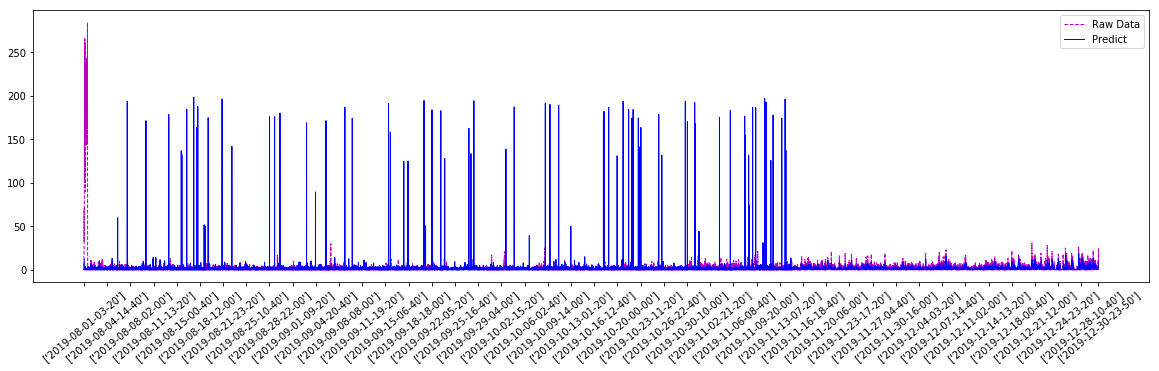

In [67]:
#Chart output
raw = scaler.inverse_transform(dataset)
x = read_csv("data4.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(raw, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),500))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()

In [68]:
#Predict output
Predict=np.ceil(Predict)
outputdata=Predict.tolist()
dataframe = read_csv("data5.csv", usecols=[0])
dataframe['predict']=pd.DataFrame(outputdata)
dataframe.to_csv('predict5.csv',index=False)

# RNN

In [69]:
#Data input
dataframe = read_csv("data5.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6

In [70]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [71]:
#Model
model = tf.keras.Sequential()
RNN = layers.SimpleRNN
model.add(RNN(1, input_shape=(lookback-1,1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=100,verbose=1)
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Epoch 1/10
15305/15305 [==============================] - 2s 118us/sample - loss: 156.1642
Epoch 2/10
15305/15305 [==============================] - 0s 15us/sample - loss: 153.0216
Epoch 3/10
15305/15305 [==============================] - 0s 16us/sample - loss: 150.6232
Epoch 4/10
15305/15305 [==============================] - 0s 16us/sample - loss: 150.6053
Epoch 5/10
15305/15305 [==============================] - 0s 15us/sample - loss: 150.5948
Epoch 6/10
15305/15305 [==============================] - 0s 15us/sample - loss: 150.5883
Epoch 7/10
15305/15305 [==============================] - 0s 15us/sample - loss: 150.5839
Epoch 8/10
15305/15305 [==============================] - 0s 16us/sample - loss: 150.5807
Epoch 9/10
15305/15305 [==============================] - 0s 16us/sample - loss: 150.5781
Epoch 10/10
15305/15305 [==============================] - 0s 16us/sample - loss: 150.5759


In [72]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.27 RMSE
Test Score: 3.09 RMSE


In [73]:
#Predict output
Predict1 = numpy.empty_like(dataset)
Predict1[:, :] = numpy.nan
Predict1[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict1[len(trainPredict)+(lookback):, :] = testPredict

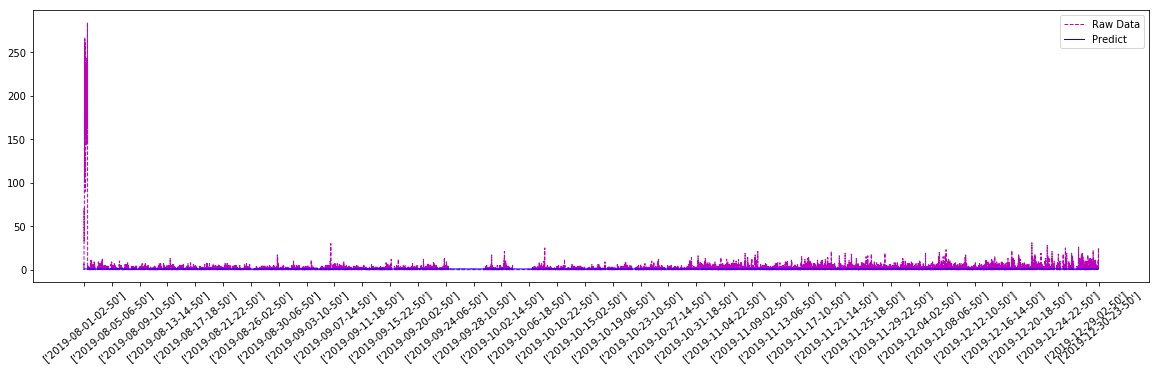

In [74]:
#Chart output
x = read_csv("data5.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(dataset, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict1, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),600))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()

# GRU

In [75]:
#Data input
dataframe = read_csv("data5.csv", usecols=[1])
dataset = dataframe.values
dataset = dataset.astype('float32')
lookback=6

In [76]:
#Data split
data = []
for index in range(len(dataset) - lookback):
    data.append(dataset[index: index + lookback])
data = numpy.array(data)
row = int(round(0.7 * data.shape[0]))
train = data[:row, :]
numpy.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = data[row:, :-1]
y_test = data[row:, -1]
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [77]:
#Model
model = Sequential()
model.add(GRU(1, return_sequences=True,input_shape=(lookback-1,1)))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_train, y_train),verbose=1)
model.summary()
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

Train on 15305 samples, validate on 15305 samples
Epoch 1/10
15305/15305 [==============================] - 2s 145us/step - loss: 140.0371 - val_loss: 151.1463
Epoch 2/10
15305/15305 [==============================] - 1s 46us/step - loss: 146.2352 - val_loss: 147.5600
Epoch 3/10
15305/15305 [==============================] - 1s 51us/step - loss: 147.1169 - val_loss: 146.7196
Epoch 4/10
15305/15305 [==============================] - 1s 46us/step - loss: 146.4793 - val_loss: 146.2500
Epoch 5/10
15305/15305 [==============================] - 1s 46us/step - loss: 145.9974 - val_loss: 145.7495
Epoch 6/10
15305/15305 [==============================] - 1s 46us/step - loss: 145.5394 - val_loss: 145.2876
Epoch 7/10
15305/15305 [==============================] - 1s 46us/step - loss: 145.1046 - val_loss: 144.8768
Epoch 8/10
15305/15305 [==============================] - 1s 46us/step - loss: 144.7225 - val_loss: 144.5897
Epoch 9/10
15305/15305 [==============================] - 1s 46us/step - loss

In [78]:
#RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.00 RMSE
Test Score: 3.63 RMSE


In [79]:
#Predict output
Predict2 = numpy.empty_like(dataset)
Predict2[:, :] = numpy.nan
Predict2[lookback:len(trainPredict)+lookback, :] = trainPredict
Predict2[len(trainPredict)+(lookback):, :] = testPredict

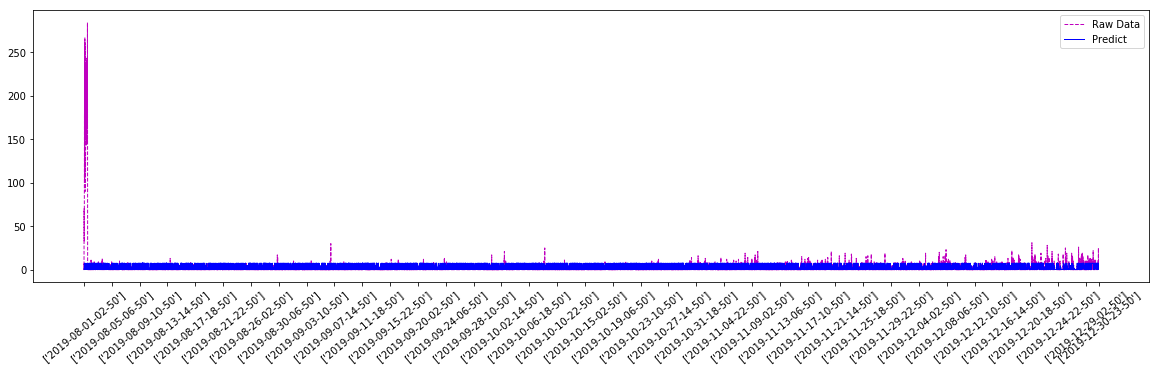

In [80]:
#Chart output
x = read_csv("data5.csv",usecols=[0]).values.tolist()
fig, ax = plt.subplots(figsize=(20,5))
raw_line, = plt.plot(dataset, "m--", linewidth=1, label="Raw Data")   
Predict_line, = plt.plot(Predict2, "b-", linewidth=1, label="Predict") 

 
plt.legend(handles=[raw_line,Predict_line])
 
xticks=list(range(0,len(x),600))
xlabels=[x[t] for t in xticks]
xticks.append(len(x))
xlabels.append(x[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
 
plt.show()